# ZMAP

This file creates a zmap, only from top, not sides.

Steps:

- Get the mask of the image using dottamine. The mask is viewed from side (mask_r). Times is usually 3 and binshape is 2, 2, 2.
- Now we do 2D morphology close using cv2 package on the mask_r with np.ones 10,10. And extract the top, left and right line. It is just the first mask pixel that appears viewed from top, left and right. We sum all of them to have a more complete line.
- Once we have the sum mask we look it from top and start doing hull (skimage package). That will help to estimate where the non-detected cells in the dome are.
- After getting the hull mask we extract the top of this hull mask.
- We do gaussian filter and epithelial process for both:
    - Hull line
    - Sum line 
- We use a more complex function to get the countour of cells using both hull and sum lines. This will result in a first approximation that is able to find dark cells and cells that are in corners (that hull would not detect at all).
- Using this first line we generate another gaussian and epithelial to then use a simpler falling line function. This will be the final result of the dome surface.

In [2]:
import skimage as sk
import matplotlib.pyplot as plt
from dottamine import dotim
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, rotate
import tifffile as tiff

In [3]:
def normalize_image(im, mult_factor = 1):
    '''
    Normalize image (any Dimensions) function.
    '''
    im = np.array(im)
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

def first_nonzero(d3_array, axis=0, moveLine=0):
    '''
    Get a line from a mask (3d array). 
    - axis can be 0, 1, 2. 
    - moveLine is the amount of pixels you want to move the line up or down.
    '''

    first_nonzero_indices = np.argmax(d3_array != 0, axis=axis)

    ## Move up or down the line
    first_nonzero_indices = first_nonzero_indices+moveLine # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher, useful for apical.
    first_nonzero_indices[first_nonzero_indices < 0] = 0
    first_nonzero_indices[first_nonzero_indices >= d3_array.shape[1]] = d3_array.shape[1]-1
    ## Fi move up or down the line

    top_mask_r = np.zeros_like(d3_array)
    top_mask_r[np.arange(d3_array.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(d3_array.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask
    if axis==0:
        top_mask_r[0,:,:] = 0
    if axis==1:
        top_mask_r[:,0,:] = 0
    if axis==2:
        top_mask_r[:,:,0] = 0

    return top_mask_r

In [27]:
time_dome = str(5)
# image = sk.io.imread('./../ppujol/zmap/62_denoised time '+time_dome+'.tif') # Image from top
image = sk.io.imread('./../ppujol/dottamine_benchmark/modified_dome_tp'+time_dome+'.tif') # Image from top
image_r = np.transpose(image, axes=(1,0,2))
image_r = np.transpose(image_r, axes=(2, 1, 0)) # Image from side front

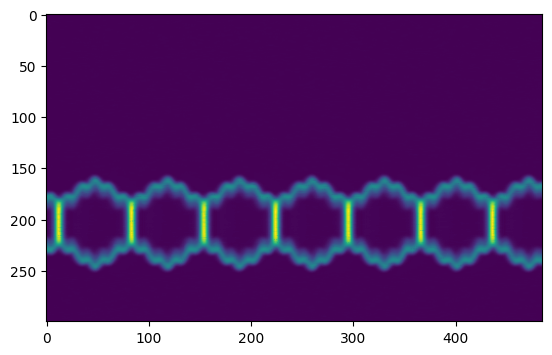

In [28]:
plt.imshow(image_r[350])

In [29]:
doter = dotim(image_r, is2D=False, treat_3D_as_2D=False) #### image or image_r
mask_r = doter.get_mask(times=3, binshape=(2,2,2), v='+') # Get the mask from side front
mask_r = mask_r.astype(np.uint16) # Make the mask uint16

# #### comment this if the image fed to doter is not from top!!!
# mask_r = np.transpose(mask_r, axes=(1,0,2))
# mask_r = np.transpose(mask_r, axes=(2, 1, 0)) # Image from side front
# #### comment this if the image fed to doter is not from top!!!


Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


In [30]:
closed_mask_r = []
for i in mask_r:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((10, 10)))
    closed_mask_r.append(full)

closed_mask = np.array(closed_mask_r) # Mask once closed

## Find the top line of the mask
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask) # Line from top
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

## Find the left line of the mask
first_left_nonzero_indices = np.argmax(closed_mask != 0, axis=2)
left_mask = np.zeros_like(closed_mask) # Line from left
left_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), first_left_nonzero_indices[None, :, None]] = 1 # Top mask is a 3D array that contains the left line of the actual mask

## Find the right line of the mask
last_right_nonzero_indices = closed_mask.shape[2] - np.argmax(closed_mask[:, :, ::-1] != 0, axis=2) - 1
right_mask = np.zeros_like(closed_mask) # Line from right
right_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), last_right_nonzero_indices[None, :, None]] = 1 # Right mask is a 3D array that contains the right line of the actual mask

sum_mask = top_mask+left_mask+right_mask # Sum of lines from top
# Make the first and last for each axis 0.
sum_mask[0, :, :] = 0
sum_mask[-1, :, :] = 0
sum_mask[:, 0, :] = 0
sum_mask[:, -1, :] = 0
sum_mask[:, :, 0] = 0
sum_mask[:, :, -1] = 0

sum_mask = np.transpose(sum_mask, axes=(1,2,0)) # Sum viewed from top

sum_mask_r = np.transpose(sum_mask, axes=(1,0,2))
sum_mask_r = np.transpose(sum_mask_r, axes=(2, 1, 0)) # Sum of lines side front

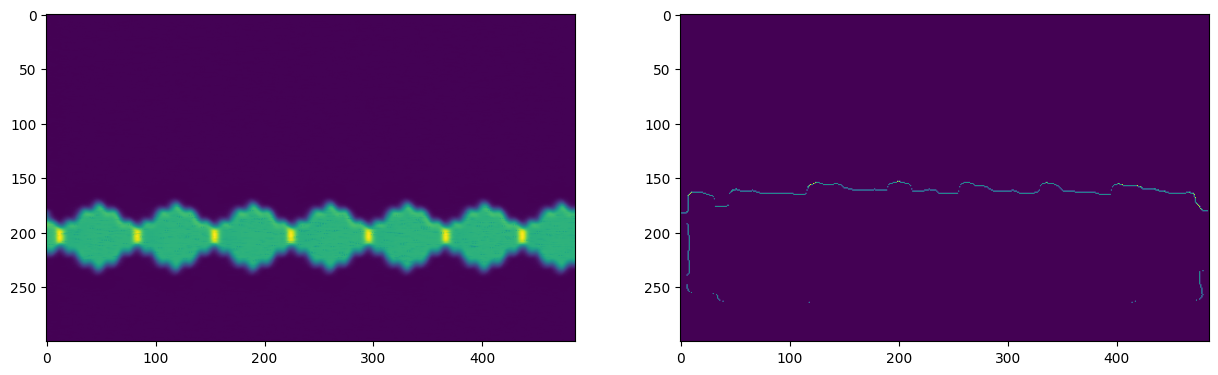

In [31]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(image_r[260])
plt.subplot(122)
plt.imshow(sum_mask_r[260])

In [8]:
# tiff.imwrite('./../ppujol/benchmarking/sum_masks'+time_dome+'test.tif', normalize_image(sum_mask_r, 65536).astype(np.uint16), imagej=True)

In [32]:
hull = []
for i in sum_mask:
    hull.append(sk.morphology.convex_hull_image(i))

hull = np.array(hull) # Hull is a closed volume that should contain all the cells or pass through them. View top
hull = hull.astype(np.uint8)

hull_r = np.transpose(hull, axes=(1,0,2))
hull_r = np.transpose(hull_r, axes=(2, 1, 0)) # Hull_r is viewed from side front

hull_mask_r = first_nonzero(hull_r, axis=1) # This is the top line of hull_r
hull_mask = np.transpose(hull_mask_r, axes=(1,2,0)) # This is the top hull line viewed from top

/tmp/ipykernel_12033/3750482522.py:3: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull.append(sk.morphology.convex_hull_image(i))


In [33]:
hull_mask = hull_mask.astype(np.float64)
filtered_hull = gaussian_filter(hull_mask, 20)
filtered_hull = normalize_image(filtered_hull)
epithelial_hull = filtered_hull*image # The gaussian cells viewed from top obtained using hull

sum_mask = sum_mask.astype(np.float64)
filtered_sum = gaussian_filter(sum_mask, 20)
filtered_sum = normalize_image(filtered_sum)
epithelial_sum = filtered_sum*image  # The gaussian cells viewed from top obtained using sum lines

epithelial_hull_r = np.transpose(epithelial_hull, axes=(1,0,2))
epithelial_hull_r = np.transpose(epithelial_hull_r, axes=(2, 1, 0)) # The epithelial obtained from hull from front

filtered_hull_r = np.transpose(filtered_hull, axes=(1,0,2)) # The gaussian obtained from hull from front
filtered_hull_r = np.transpose(filtered_hull_r, axes=(2, 1, 0))

epithelial_sum_r = np.transpose(epithelial_sum, axes=(1,0,2))
epithelial_sum_r = np.transpose(epithelial_sum_r, axes=(2, 1, 0)) # The epithelial obtained from sum from front

filtered_sum_r = np.transpose(filtered_sum, axes=(1,0,2))
filtered_sum_r = np.transpose(filtered_sum_r, axes=(2, 1, 0)) # The gaussian obtained from sum from front

In [34]:
def shape_finder_2D(epithelial, angle=40):
    '''
    Falling line algorithm for 2D front image rotation, delta degree = 20º
    - epithelial is the 2D image that has to be fed from front
    - angle is the max rotation for the 2D image
    '''

    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [-40]
    total_cell_mask = np.zeros(shape=(epithelial.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(epithelial, angle, reshape=False) # Be careful of the reshape=False
        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))

            if max_pos <= len(col)*0.95 and max_pos >= len(col)*0.05 and max(col) >= col.mean()+2*col.std(): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)


def shape_finder_2D_v2(hull_lines, hull_mask, sum_lines, sum_mask, angle=40):
    '''
    Get the first approximation using hull and sum lines, delta degree = 20º
    - hull_lines is the epithelial obtained from hull mask
    - hull_mask is the gaussian or the line obtained using hull from front
    - sum_lines is the epithelial obtained from sum mask
    - sum_mask is the gaussian or the line obtained using hull from front
    - angle is the max rotation for the 2D image
    '''
    angles = [i for i in range(-angle, angle+1, 20)]
    # angles = [40]
    total_cell_mask = np.zeros(shape=(hull_lines.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_hull_lines = rotate(hull_lines, angle, reshape=False) # Be careful of the reshape=False
        rot_hull_mask = rotate(hull_mask, angle, reshape=False)
        rot_sum_lines = rotate(sum_lines, angle, reshape=False)
        rot_sum_mask = rotate(sum_mask, angle, reshape=False)
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_hull_lines.shape[1]):
            col_hull_lines = rot_hull_lines[:, i]
            max_pos_hull_lines = np.argmax(col_hull_lines == max(col_hull_lines))
            col_hull_mask = rot_hull_mask[:, i]
            max_pos_hull_mask = np.argmax(col_hull_mask == max(col_hull_mask))

            col_sum_lines = rot_sum_lines[:, i]
            max_pos_sum_lines = np.argmax(col_sum_lines == max(col_sum_lines))
            col_sum_mask = rot_sum_mask[:, i]
            max_pos_sum_mask = np.argmax(col_sum_mask == max(col_sum_mask))

            # print(max_pos_hull_lines, max_pos_hull_mask, abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask)


            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            if ((max_pos_hull_lines <= len(col_hull_lines)*0.90) and (max_pos_hull_lines >= len(col_hull_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_hull_lines) # Search for the first max

            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            elif ((max_pos_sum_lines <= len(col_sum_lines)*0.90) and (max_pos_sum_lines >= len(col_sum_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_sum_lines) # Search for the first max

            else:
                cell_border.append('-')
                # cell_border.append(max_pos_sum_lines) 

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_hull_lines)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

In [35]:
surface_cells_r = []
c = 0
total = epithelial_hull_r.shape[0]
for i, j, k, l in zip(normalize_image(epithelial_hull_r), normalize_image(hull_mask_r), normalize_image(epithelial_sum_r), normalize_image(sum_mask_r)):
    surface_cells_r.append(shape_finder_2D_v2(i, j, k, l))
    c+=1
    print(f"{c}/{total}", end='\r')
surface_cells_r = np.array(surface_cells_r) # This is the first iteration of falling line using both hull and sum lines

surface_cells = np.transpose(surface_cells_r, axes=(1,2,0)) # Rotate the surface cells to be viewed from top
surface_cells = surface_cells.astype(np.uint16) ### MISSING NORMALIZE?

/tmp/ipykernel_12033/3244055318.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_12033/3244055318.py:92: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE


In [36]:
tiff.imwrite('./../ppujol/dottamine_benchmark/modified_dome_tp'+time_dome+'surface_cells_mid.tif', surface_cells, imagej=True)

In [40]:
surface_cells = sk.io.imread('./../ppujol/dottamine_benchmark/modified_dome_tp'+time_dome+'surface_cells_mid.tif')

In [41]:
dots_mask_mask = surface_cells.astype(np.float64)
filtered_mask_mask = gaussian_filter(dots_mask_mask, 20) # This is the gaussian obtained from the first iteration
filtered_mask_mask = normalize_image(filtered_mask_mask)
epithelial_mask_mask = filtered_mask_mask*image # Epithelial from the first iteration

epithelial_mask_mask_r = np.transpose(epithelial_mask_mask, axes=(1,0,2))
epithelial_mask_mask_r = np.transpose(epithelial_mask_mask_r, axes=(2, 1, 0)) # First iteration from front

filtered_mask_mask_r = np.transpose(filtered_mask_mask, axes=(1,0,2))
filtered_mask_mask_r = np.transpose(filtered_mask_mask_r, axes=(2, 1, 0)) # First gaussian from front

In [42]:
surface_cells_mask_r = []
c = 0
total = epithelial_mask_mask_r.shape[0]
for i in epithelial_mask_mask_r:
    surface_cells_mask_r.append(shape_finder_2D(i))
    c+=1
    print(f"{c}/{total}", end='\r')
surface_cells_mask_r = np.array(surface_cells_mask_r) # This is the 'final dot-cell result

surface_cells_mask_filter_r = surface_cells_mask_r * filtered_mask_mask_r # the result multiplied by the filter

surface_cells_mask = np.transpose(surface_cells_mask_r, axes=(1,2,0))
surface_cells_mask = normalize_image(surface_cells_mask, 65535)
surface_cells_mask = surface_cells_mask.astype(np.uint16) # Raw dots without gaussian

surface_cells_mask_filter = np.transpose(surface_cells_mask_filter_r, axes=(1,2,0))
surface_cells_mask_filter = normalize_image(surface_cells_mask_filter, 65535)
surface_cells_mask_filter = surface_cells_mask_filter.astype(np.uint16) # Dots with gaussian

The whole process took around 12:20

In [43]:
# tiff.imwrite('./../ppujol/zmap/tp'+time_dome+'/cells_mask_filter.tif', normalize_image(surface_cells_mask_filter, 65536).astype(np.uint16), imagej=True)
# tiff.imwrite('./../ppujol/zmap/tp'+time_dome+'/epithelial_mask_filter.tif', normalize_image(epithelial_mask_mask, 65536).astype(np.uint16), imagej=True)

tiff.imwrite('./../ppujol/dottamine_benchmark/modified_dome_tp'+time_dome+'cells_mask_filter.tif', normalize_image(surface_cells_mask_filter, 65536).astype(np.uint16), imagej=True)
tiff.imwrite('./../ppujol/dottamine_benchmark/modified_dome_tp'+time_dome+'epithelial_mask_filter.tif', normalize_image(epithelial_mask_mask, 65536).astype(np.uint16), imagej=True)

# End of falling line

Now we should have a proper position of the cells. We can transform this onto a height map. Or we could smooth this line and then make a gaussian to multiply by the image, find the brightest point and position and then build a height map.

# Height Map

We will use the dots obtained thanks to the dot cloud

In [47]:
# surface_cells_mask_filter = sk.io.imread('./../ppujol/zmap/tp'+str(1)+'/cells_mask_filter.tif')
# time_dome = str(5)
surface_cells_mask_filter = sk.io.imread('./../ppujol/dottamine_benchmark/modified_dome_tp'+time_dome+'epithelial_mask_filter.tif')

In [48]:
max_intensity_indices = np.argmax(surface_cells_mask_filter, axis=0)
max_intensity_indices[:4, :] = max_intensity_indices[5, :]
max_intensity_indices[-4:, :] = max_intensity_indices[-5, :]
max_intensity_values = np.max(surface_cells_mask_filter, axis=0)

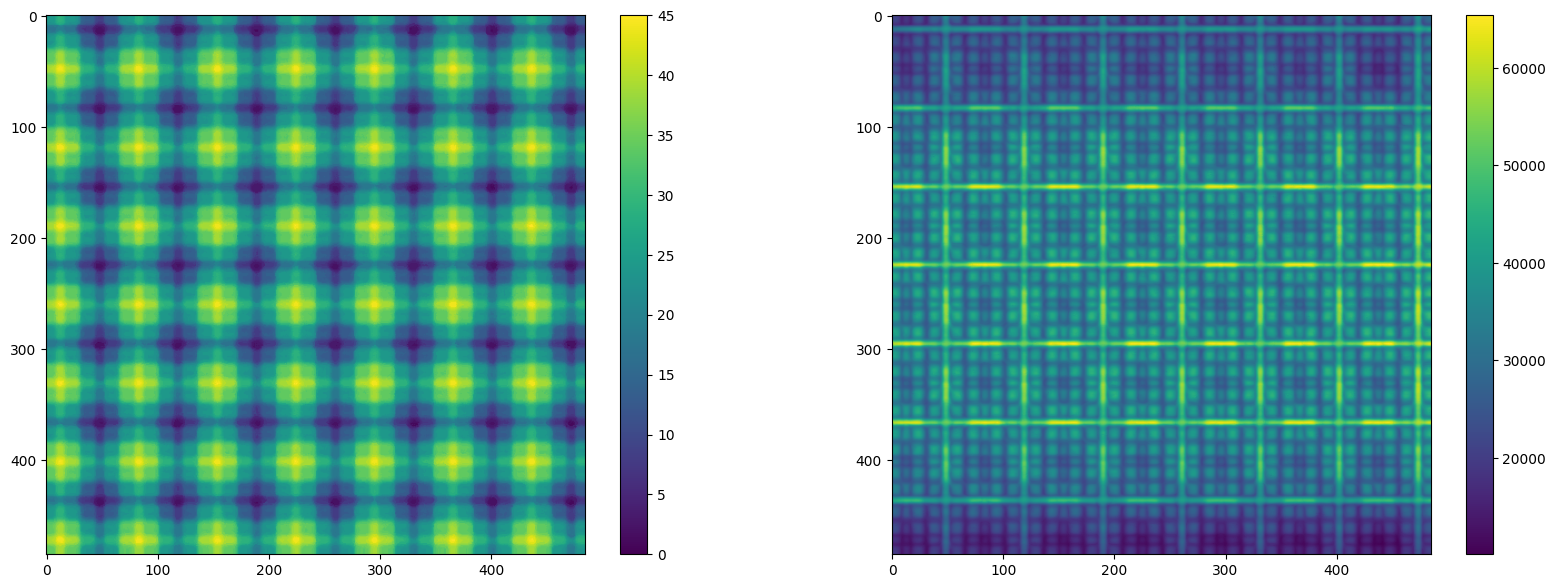

In [49]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.imshow(reverse_values(max_intensity_indices))
plt.colorbar()
plt.subplot(122)
plt.imshow(max_intensity_values)
plt.colorbar()

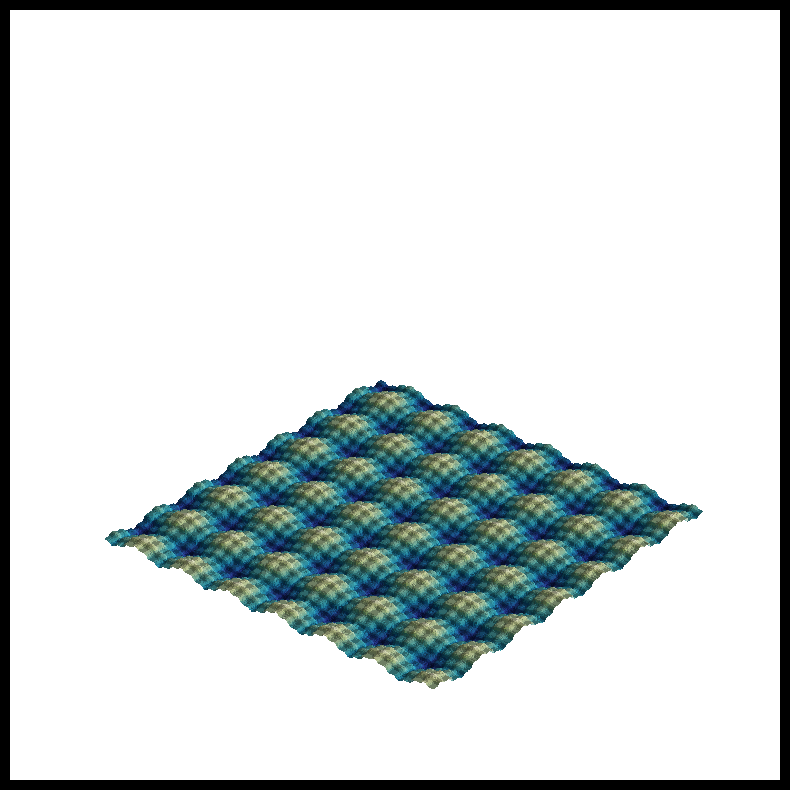

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
import scipy.ndimage as ndi
import copy
import matplotlib.colors as clr


colors = ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58']
colors.reverse()
cmap = clr.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

heightmap = copy.copy(reverse_values(max_intensity_indices))
# heightmap = heightmap[0:750, 0:750]
# heightmap = heightmap[200:700, 100:600]

# heightmap = ndi.gaussian_filter(heightmap, 1) # To smooth the map a bit
# Generate X and Y coordinates
x, y = np.meshgrid(np.arange(heightmap.shape[1]), np.arange(heightmap.shape[0]))


# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


ax.view_init(elev=30, azim=-50, roll=0)

# ax.plot_surface(-x,-y, heightmap, cmap=cmap)


ls = LightSource(azdeg=90, altdeg=30) # azimut and elevation
rgb = ls.shade(heightmap, cmap=cmap, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(y, x, heightmap, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, shade=True)


# ls = LightSource(0, 45) # azimut and elevation
# cmap = plt.get_cmap("cividis")
# rgb = ls.shade(heightmap, cmap=cmap, vert_exag=0.1, blend_mode='soft')
# surf = ax.plot_surface(y, -x, heightmap, rstride=1, cstride=1, facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=False)


ax.set_zlim(0, 650)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')





# Set the background to black
fig.patch.set_facecolor('black')

# Hide the axes
ax.set_axis_off()



# Show the plot
plt.show()
